# **RSNA Pneumonia Detection Competition **

Our aim in this notenook is to find the possibility of penumonia in set of x-rays. For that we have sample traning X-rays which have both type the images, which have Pneumonia and Images which dont have Pneumonia. we will use Keras Libraris and create a neural network which will detecte images have Pneumonia or not. We will try to visualize data as well and represent diffrent cases whcih effect higher case of pnemonia.

We will Import Important Libraries whcih will help in reading, shuffling, visualizing, creating network and process the images.

In [0]:
import os  # For Reading file
import csv # creating csv sample submission
import random  # Shuffling image and data set to split in train and test 
!pip install -U -q pydicom # Needed to install 
import pydicom # Reading DMC Images or X-rays Images
import numpy as np # Converting images in array to feed in Neural Network
import pandas as pd # Read CSV
import multiprocessing
import seaborn as sns
import warnings
from skimage import io  #writing in folder and Input output processing
from skimage import measure  # cheking file size 
from skimage.transform import resize # converting File Size to pass in neural network

import tensorflow as tf # for CNN and network creating
from tensorflow import keras 

from matplotlib import pyplot as plt # ploting Images, Visualizaton library
import matplotlib.patches as patches

warnings.filterwarnings('ignore')

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
 !pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
#file_id = '1mgH7u9T201TWJv4B0Jt6lrqOGQ5XOCXR'
#downloaded = drive.CreateFile({'id': file_id})
#print('Downloaded content "{}"'.format(downloaded.GetContentString()))


# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1mgH7u9T201TWJv4B0Jt6lrqOGQ5XOCXR' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

     |████████████████████████████████| 993kB 4.9MB/s 


In [0]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join('/root/data/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

In [0]:
data_frame = pd.read_csv('/root/data/stage_2_train_labels.csv')
data_frame['aspect_ratio'] = (data_frame['width']/data_frame['height'])
data_frame['area'] = data_frame['width'] * data_frame['height']

In [0]:
print(pneumonia_locations)

In [0]:
!mkdir stage_2_train_images
os.chdir('stage_2_train_images')
!unzip /root/data/stage_2_train_images.zip

In [0]:
def get_dcim_info(filename):
  fn = os.path.join('',f'{filename}.dcm')
  dcm_data = pydicom.read_file(fn)
  return {'age': dcm_data.PatientAge,
         'gender': dcm_data.PatientSex,
         'id': dcm_data.PatientID,
         'pixel_spacing': float(dcm_data.PixelSpacing[0]),
         'mean_black_pixels': np.mean(dcm_data.pixel_array == 0)}


patient_ids = list(data_frame.patientId.unique())
with multiprocessing.Pool(4) as pool:
    result = pool.map(get_dcim_info, patient_ids)
    
demo = pd.DataFrame(result)
demo['gender'] = demo['gender'].astype('category')
demo['age'] = demo['age'].astype(int)

data_frame = (data_frame.merge(demo, left_on='patientId', right_on='id', how='left')
        .drop(columns='id'))

print('finished')

#content/stage_2_train_images/33b759a7-cc42-4d7e-8f54-c1a32b389674.dcm

In [0]:
boxes_per_patient = data_frame.groupby('patientId')['Target'].sum()

ax = (boxes_per_patient > 0).value_counts().plot.bar()
_ = ax.set_title('Are the classes imbalanced?')
_ = ax.set_xlabel('Has Pneumonia')
_ = ax.set_ylabel('Count')
_ = ax.xaxis.set_tick_params(rotation=0)

print('finished')

In [0]:
centers = (data_frame.dropna(subset=['x'])
           .assign(center_x=data_frame.x + data_frame.width / 2, center_y=data_frame.y + data_frame.height / 2))
ax = sns.jointplot("center_x", "center_y", data=centers, height=9, alpha=0.1)
_ = ax.fig.suptitle("Where is Pneumonia located?", y=1.01)

In [0]:
g = sns.FacetGrid(col='Target', hue='gender', 
                  data=data_frame.drop_duplicates(subset=['patientId']), 
                  height=9, palette=dict(F="red", M="blue"))
_ = g.map(sns.distplot, 'age', hist_kws={'alpha': 0.3}).add_legend()
_ = g.fig.suptitle("What is the age distribution by gender and target?", y=1.02, fontsize=20)

In [0]:
from sklearn.mixture import GaussianMixture
clf = GaussianMixture(n_components=2)
clf.fit(centers[['center_x', 'center_y']])
center_probs = clf.predict_proba(centers[['center_x', 'center_y']])
Z = -clf.score_samples(centers[['center_x', 'center_y']])
outliers = centers.iloc[Z > 17]
fig, ax = plt.subplots()
centers.plot.scatter('center_x', 'center_y', c=Z, alpha=0.5, cmap='viridis', ax=ax)
outliers.plot.scatter('center_x', 'center_y', c='red', marker='x', s=100, ax=ax)
_ = ax.set_title('Where are the outliers?', fontsize=18)

In [0]:
# load and shuffle filenames
os.chdir('..')
folder = '/content/stage_2_train_images/'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2200
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

In [0]:
print('Total train images:',len(filenames))
print('Images with pneumonia:', len(pneumonia_locations))

ns = [len(value) for value in pneumonia_locations.values()]
plt.figure()
plt.hist(ns)
plt.xlabel('Pneumonia per image')
plt.xticks(range(1, np.max(ns)+1))
plt.show()

heatmap = np.zeros((1024, 1024))
ws = []
hs = []
for values in pneumonia_locations.values():
    for value in values:
        x, y, w, h = value
        heatmap[y:y+h, x:x+w] += 1
        ws.append(w)
        hs.append(h)
plt.figure()
plt.title('Pneumonia location heatmap')
plt.imshow(heatmap)
plt.figure()
plt.title('Pneumonia height lengths')
plt.hist(hs, bins=np.linspace(0,1000,50))
plt.show()
plt.figure()
plt.title('Pneumonia width lengths')
plt.hist(ws, bins=np.linspace(0,1000,50))
plt.show()
print('Minimum pneumonia height:', np.min(hs))
print('Minimum pneumonia width: ', np.min(ws))

In [0]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in self.pneumonia_locations:
            # loop through pneumonia
            for location in self.pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [0]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

The kaggle challenge makes efforts to define the grading system that will be applied. It is the Jaccard loss function, or intersection over union (IoU). We combine it with a binary cross entropy (bce) loss.

In [17]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# create network and compiler
model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 10
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# create train and validation generators
folder = '/content/stage_2_train_images/'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=False, predict=False)

history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=10, workers=4, use_multiprocessing=True)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
765/765 [==============================] - 1236s 2s/step - loss: 15.5332 - acc: 0.9607 - mean_iou: 0.6172 - val_loss: 16.6349 - val_acc: 0.9393 - val_mean_iou: 0.3005
Epoch 2/10
765/765 [==============================] - 949s 1s/step - loss: 14.5496 - acc: 0.9655 - mean_iou: 0.6591 - val_loss: 14.8686 - val_acc: 0.9726 - val_mean_iou: 0.7209
Epoch 3/10
765/765 [==============================] - 1000s 1s/step - loss: 14.1991 - acc: 0.9668 - mean_iou: 0.6730 - val_loss: 23.2051 - val_acc: 0.8250 - val_mean_iou: 0.1403
Epoch 4/10
765/765 [==============================] - 1006s 1s/step - loss: 13.9678 - acc: 0.9676 - mean_iou: 0.6768 - val_loss: 14.1292 - val_acc: 0.9699 - val_mean_iou: 0.6734
Epoch 5/10
765/765 [==============================] - 1014s 1s/step - loss: 13.7073 - acc: 0.9684 - mean_iou: 0.6848 - val_loss: 14.2350 - val_acc: 0.9584 - val_mean_iou

In [0]:
#scores = model.evaluate(train_gen, verbose = 0)c

#print("Accuracy: {} \n Error: {}".format(scores[1]*100, 100-scores[1]*100))

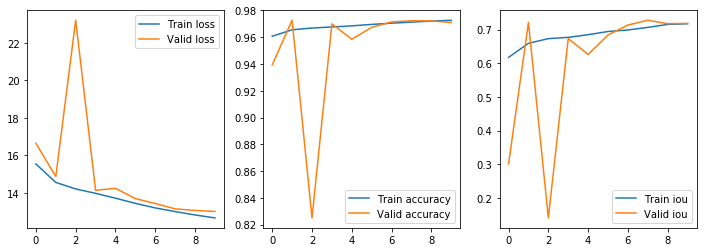

In [18]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

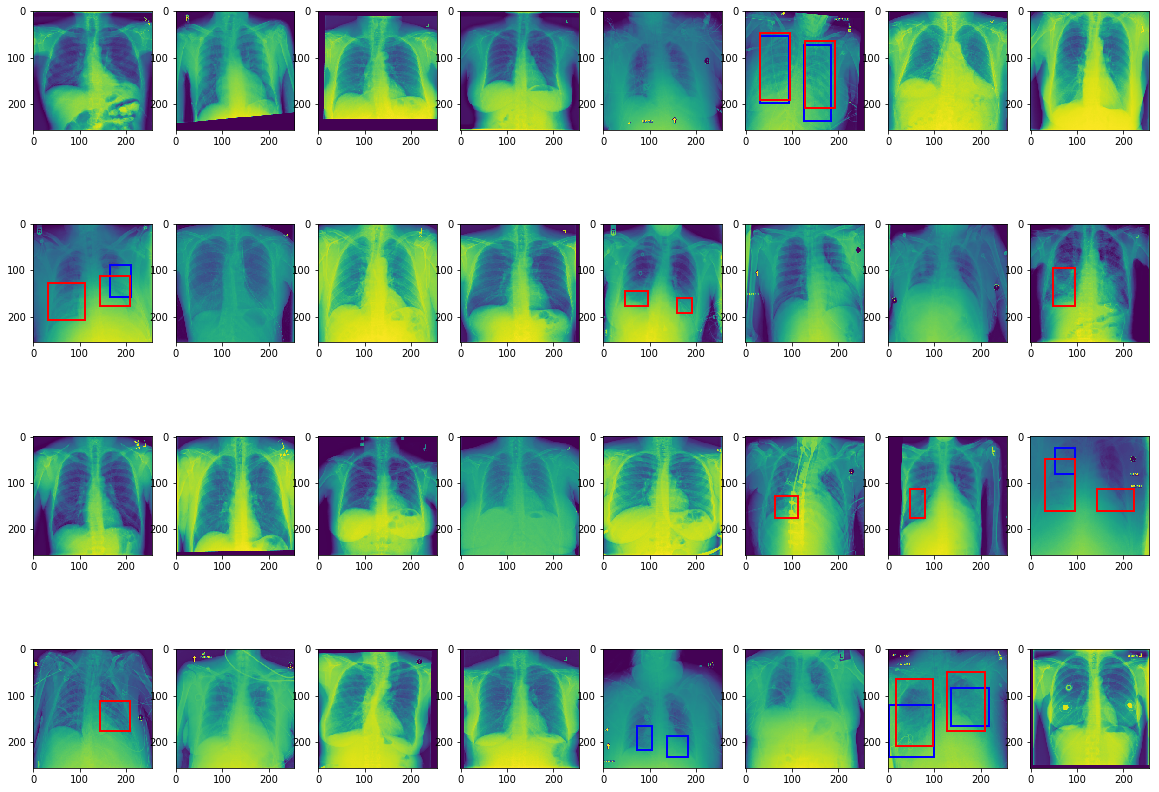

In [19]:
for imgs, msks in valid_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break

In [20]:
cd ..

/


In [21]:

!mkdir stage_2_test_images
os.chdir('stage_2_test_images')
!unzip -qq /root/data/stage_2_test_images.zip

Archive:  /root/data/stage_2_test_images.zip
  inflating: 043d020e-c61b-40ac-8704-be5ed7ded293.dcm  
  inflating: 2a655317-ec64-47b8-b3ca-6b347b7aad2f.dcm  
  inflating: 2836c671-b555-4af7-b1c2-25d73cb113f1.dcm  
  inflating: 26f13439-9e01-443c-a503-bd8340cb7bdf.dcm  
  inflating: 042d37c9-b83f-40f6-8d8e-85022c7f3a14.dcm  
  inflating: 2c106e49-84cd-4824-a12c-c2e737f31fd7.dcm  
  inflating: 30c8b24b-4a43-40fd-9d71-bb2eea4fa1b8.dcm  
  inflating: 264d4100-0a4a-460d-81fd-e781bbf6ca86.dcm  
  inflating: 19ec8e70-0d6e-4912-930a-d16c280decec.dcm  
  inflating: 2ba33562-3b2a-4d4b-9a8d-2da5100c2a9d.dcm  
  inflating: c07ea5c4-ce0a-4f94-bcfe-64c7399adb9c.dcm  
  inflating: c01eda59-a25b-4995-8f4d-863a1e633826.dcm  
  inflating: 295e7fd7-dfcc-4945-a8bc-b7bfcaea26ed.dcm  
  inflating: 136d904b-6dd5-4ef1-a504-a196dfbf73c3.dcm  
  inflating: 012e4288-deac-438d-af9e-a3cb7478ed7f.dcm  
  inflating: 035c8891-656e-4422-82a0-a53406dae9ba.dcm  
  inflating: 13bd80c3-a3a0-4a2a-83c2-4b298a1f47a0.dcm  
  i

In [22]:
# load and shuffle filenames
folder = '../stage_2_test_images/'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=25, image_size=256, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break

print(submission_dict)

n test samples: 3000
{'3090e21b-706b-4ddb-b730-a5276b953bd7': '0.9057321146839664 576 128 256 576 0.9491181612492559 192 191 256 450 ', '1a27e565-b0f5-4419-84b3-744712cb705d': '0.5829862063561364 641 705 126 190 ', '0efd119a-5eba-4c61-8d9e-56380651b4d9': '0.8114871373010041 255 384 194 192 ', 'c05a341f-e8b7-438b-a8d7-146dd746a2aa': '', '1fc7fea2-7b2e-4fe0-a74f-6f7e6ba86e4f': '', '2ebc2dbb-9603-48b0-8cf1-20c087cebb4d': '', '047033df-5509-4b5b-9861-351b9a0bf4c4': '0.6816607365006182 766 640 129 191 ', '0550c5d5-941c-4995-9276-6401a8a4ffbe': '', '20cf7cea-879e-47fe-937c-15a258dff0e3': '', '1c7dda21-aa7e-4db4-84b3-7a039779ce27': '0.6344490259171823 319 385 130 191 ', '1a0ca228-5501-49f8-85e6-c5e66ecd2d74': '', '2ba09a39-3935-4b61-8119-266a0fa153ec': '', '25b057bc-7363-4904-81f3-92c50d94486f': '', '02b42e7e-d0da-43b7-9a54-458264099d08': '0.7877469766088397 577 256 255 320 ', '30045189-e13e-4fb1-9814-f79d9ac703dd': '', '105d515f-b44e-4ba6-b4b1-b00b5354597e': '', '1aefa92d-c179-4ced-8006-0df6

In [23]:
#This doesnt work
print('Total train images:',len(test_filenames))
print('Images with pneumonia:', len(submission_dict))

Total train images: 3000
Images with pneumonia: 3000


In [0]:
# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']

In [27]:
sub.sample(10)

,PredictionString
patientId,
0f750c99-7add-4129-a7b4-21000786d550,
125917b3-7c5c-4d83-b6e5-6ca2fc79f5a0,0.8691494690068465 576 193 192 447 0.683494433...
0dfe9ea1-0a54-475a-b44e-76cab0e078c9,
0005d3cc-3c3f-40b9-93c3-46231c3eb813,
2c7a42ba-3b07-4cbf-84f3-0fe7f4379bf2,
27ac2172-04c3-4735-ac40-3a9317a411d3,0.8281333408449237 576 447 320 385 0.740166954...
1cf2eae5-29f3-4a1c-bce7-c9ade8554d1b,0.7813931517200593 576 321 256 383 0.607938027...
02a378a0-0229-4f11-9a1c-bf32332645da,
10fc4fbc-0aad-447b-a9bc-88e840b409bb,


People with Pneumonia is: 
False    2156
True      844
Name: PredictionString, dtype: int64


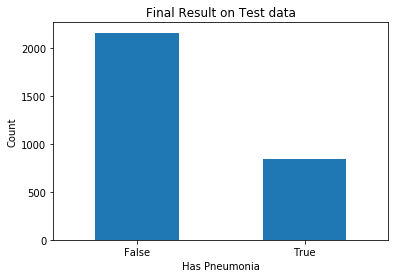

In [47]:
boxes_per_patient = sub.groupby('patientId')['PredictionString'].sum()

ax = (boxes_per_patient > '' ).value_counts().plot.bar()
_ = ax.set_title('Final Result on Test data')
_ = ax.set_xlabel('Has Pneumonia')
_ = ax.set_ylabel('Count')
_ = ax.xaxis.set_tick_params(rotation=0)

print("People with Pneumonia is: \n" + str((boxes_per_patient > '' ).value_counts()))


In [41]:
new = sub["PredictionString"].str.split(" ", expand = True)

new.sample(10)

#print(pd.isnull(new).sum())

0        0
1     2156
2     2156
3     2156
4     2156
5     2156
6     2572
7     2572
8     2572
9     2572
10    2572
11    2992
12    2992
13    2992
14    2992
15    2992
16    2999
17    2999
18    2999
19    2999
20    2999
dtype: int64


In [0]:


ns = [len(value) for value in pneumonia_locations.values()]
plt.figure()
plt.hist(ns)
plt.xlabel('Pneumonia per image')
plt.xticks(range(1, np.max(ns)+1))
plt.show()

heatmap = np.zeros((1024, 1024))
ws = []
hs = []
for values in pneumonia_locations.values():
    for value in values:
        x, y, w, h = value
        heatmap[y:y+h, x:x+w] += 1
        ws.append(w)
        hs.append(h)
plt.figure()
plt.title('Pneumonia location heatmap')
plt.imshow(heatmap)
plt.figure()
plt.title('Pneumonia height lengths')
plt.hist(hs, bins=np.linspace(0,1000,50))
plt.show()
plt.figure()
plt.title('Pneumonia width lengths')
plt.hist(ws, bins=np.linspace(0,1000,50))
plt.show()
print('Minimum pneumonia height:', np.min(hs))
print('Minimum pneumonia width: ', np.min(ws))

boxes_per_patient = sub.groupby('patientId')['Target'].sum()

ax = (boxes_per_patient > 0).value_counts().plot.bar()
_ = ax.set_title('Are the classes imbalanced?')
_ = ax.set_xlabel('Has Pneumonia')
_ = ax.set_ylabel('Count')
_ = ax.xaxis.set_tick_params(rotation=0)

In [0]:
sub.to_csv('submission.csv')